In [60]:
import pycoingecko
import pandas as pd
import datetime
import seaborn as sb
import requests
import yfinance as yf
import statsmodels.api as sm
from scipy.stats import norm 
import scipy as sp
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from factor_analyzer import FactorAnalyzer
import time
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
from pycoingecko import CoinGeckoAPI
import plotly.express as px

cg = CoinGeckoAPI()
node_base_url = "http://mantle-archival-private-www-673419417.ap-northeast-2.elb.amazonaws.com"

import warnings
warnings.filterwarnings("ignore")

In [61]:
#!pip install plotly --user
#!pip install factor_analyzer --user
#!pip install advanced-pca --user
#!pip install lightgbm --user

#import os
#os.environ['R_HOME'] = '/path/to/R'

Use get_coin_market_chart_by_id, the wrapper around /coins/{id}/market_chart to get historical market data. The granularity of the data returned depends on the number of days we are getting:

minutely data for duration within 1 day
hourly data will be used for duration between 1 day and 90 days
daily data will be used for duration above 90 days

In [62]:
def plot_features(df_act, caption):

    fig, axs = plt.subplots(8, 3,figsize=(30, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.2, top=0.9)
    fig.suptitle(caption,fontweight = 'bold',fontsize = 15)
    axes_list = [item for sublist in axs for item in sublist] 

    for i, col in enumerate(df_act.columns):

        ax = axes_list.pop(0)
        data1 = df_act[col].values
        name=col
        ax.plot(data1, '.')
        ax.set_title(name)

    for ax in axes_list:
        ax.remove()

In [63]:
def plot_histograms(df_act, caption):

    fig, axs = plt.subplots(10, 2,figsize=(20, 20))
    fig.subplots_adjust(hspace=1.5, wspace=0.2, top=0.9)
    fig.suptitle(caption,fontweight = 'bold',fontsize = 15)
    axes_list = [item for sublist in axs for item in sublist] 

    for i, col in enumerate(df_act.columns):

        ax = axes_list.pop(0)
        data1 = df_act[col].values
        name=col
        ax.hist(data1, density=True, bins=200, log=True, edgecolor='none')

        ax.set_title(name)

    for ax in axes_list:
        ax.remove()

In [64]:
def plot_pair_scatterplots(df, caption):    
    
    fig, axs = plt.subplots(10, 5, figsize=(20, 10))
    fig.subplots_adjust(hspace=1, wspace=0.7, top=0.9)

    fig.suptitle(caption, fontweight = 'bold', fontsize = 15)
    axes_list = [item for sublist in axs for item in sublist] 

    i = 0
    col_choice = df.columns
    
    for pos, axis1 in enumerate(col_choice):   
        for p, axis2 in enumerate(col_choice[pos+1:]):  
            ax = axes_list.pop(0)
            ax.plot(df[axis1], df[axis2], ".", alpha=1)
            ax.set_xlabel(axis1, fontsize = 8)
            ax.set_ylabel(axis2, fontsize = 8)

            cor = np.corrcoef(df[axis1], df[axis2])[0,1]
            r = np.round(cor,2)

            title_text = 'ra=%0.2f'% (r)
            ax.set_title(title_text, fontsize=12)

    for ax in axes_list:
        ax.remove()

In [65]:
def normalize(df, coeff_info):
    '''
    min-max scaler
    '''
    #normalized_df=(df-df.min())/(df.max()-df.min())
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        check_sign = coeff_info['Sign of dependence'][coeff_info['Coefficient'] == feature_name]
        #print(check_sign[0])
        if int(check_sign) == -1:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value) * 100
        else:
            result[feature_name] = (max_value - df[feature_name]) / (max_value - min_value) * 100
    return result

In [66]:
def quantile_norm(features_df, coeff_info):
    
    transformed_data = pd.DataFrame()
    coeff_borders = pd.DataFrame(columns=['Coeff name', 'Start border', 'End Border'])
    coeff_quantile = pd.DataFrame()
    mark = [x for x in range(1, 101)]

    data = features_df.copy()
    data = data.reset_index()

    # Transformation
    for i in range(1, len(data.columns)):
        # Determination of general information about the coefficient: name, sign of dependence on default, domain of definition
        coeff_name = data.columns[i]
        check_sign = coeff_info['Sign of dependence'][coeff_info['Coefficient'] == coeff_name]
        left_border = coeff_info['Left border'][coeff_info['Coefficient'] == coeff_name]
        right_border = coeff_info['Right border'][coeff_info['Coefficient'] == coeff_name]

        coeff_val = pd.to_numeric(data.iloc[:, i])  # vector of coefficient values

        # vector of coefficient values excluding the values NA and +-infinity
        coeff_val_filt = coeff_val[(coeff_val.isnull() == False) & (coeff_val != -999999) & (coeff_val != 999999)]

        # Finding Interquartile Distance to Filter Outliers
        quantile = coeff_val_filt.quantile(np.arange(0.0, 1.0, 0.01))
        Q_1 = quantile.iloc[10]
        Q_3 = quantile.iloc[90]
        interquantile_range = Q_3 - Q_1
        start_border = Q_1 - interquantile_range*3
        end_border = Q_3 + interquantile_range*3

        # Exclusion of outliers
        print(sum((coeff_val_filt < start_border) | (coeff_val_filt > end_border)))
        coeff_val_filt = coeff_val_filt[(coeff_val_filt >= start_border) & (coeff_val_filt <= end_border)]
        
        quantile = coeff_val_filt.quantile(np.arange(0.0, 1.0, 0.01))
        quantile.index = np.arange(len(quantile))
        qLen = len(quantile)

        # Bringing the obtained domain values to a convenient format for working in the environment
        try:
            left_border = int(left_border)
        except Exception as e:
            try:
                left_border = left_border.iloc[0]
            except Exception:
                pass

        try:
            right_border = int(right_border)
        except Exception as e:
            try:
                right_border = right_border.iloc[0]
            except Exception:
                pass

        if left_border == 0:
            if start_border < left_border:
                start_border = left_border

        if left_border == "minus_inf":
            start_border = -math.inf

        if right_border == 0:
            if end_border > right_border:
                end_border = right_border
        if right_border == "plus_inf":
            end_border = math.inf

        coeff_borders = coeff_borders.append(
            {'Coeff name': coeff_name, 'Start border': start_border, 'End Border': end_border},
            ignore_index=True,
        )
        coeff_quantile[coeff_name] = quantile

        # Assigning a score to each coefficient depending on the sign of the dependence on default
        coeff = coeff_val
        # In the case of inverse dependence on quality
        if int(check_sign) == -1:
            mark_to_add = pd.Series([mark[0]] * len(coeff))
            mark_to_add[coeff == float(-999999)] = mark[0]
            mark_to_add[coeff == float(999999)] = mark[qLen-1]
            mark_to_add[(coeff >= start_border) & (coeff <= quantile[0])] = mark[0]
            mark_to_add[(coeff >= quantile[qLen-1]) & (coeff <= end_border)] = mark[qLen-1]
            for k in range(1, qLen-1):
                mark_to_add[(coeff > quantile[k]) & (coeff <= quantile[k+1])] = mark[k]
        # In case of direct dependence on default
        if int(check_sign) == 1:
            mark_to_add = pd.Series([mark[qLen-1]] * len(coeff))
            mark_to_add[coeff == float(-999999)] = mark[qLen-1]
            mark_to_add[coeff == float(999999)] = mark[0]
            mark_to_add[(coeff >= start_border) & (coeff <= quantile[0])] = mark[qLen-1]
            mark_to_add[(coeff >= quantile[qLen-1]) & (coeff <= end_border)] = mark[0]
            for k in range(1, qLen-1):
                mark_to_add[(coeff > quantile[k]) & (coeff <= quantile[k+1])] = mark[qLen-k]
        # Adding transformed coefficient values to the resulting table
        transformed_data[data.columns[i]] = mark_to_add
        
    transformed_data.index = features_df.index
    return transformed_data

# Get Daily Data

In [67]:
price_df = pd.read_csv('price_df.csv', sep=';')
vol_df = pd.read_csv('vol_df.csv', sep=';')
mcap_df = pd.read_csv('mcap_df.csv', sep=';')

price_df.index = price_df['time']
price_df.drop('time', axis=1, inplace=True)
price_df.index = pd.DatetimeIndex(price_df.index)

vol_df.index = vol_df['time']
vol_df.drop('time', axis=1, inplace=True)
vol_df.index = pd.DatetimeIndex(vol_df.index)

mcap_df.index = mcap_df['time']
mcap_df.drop('time', axis=1, inplace=True)
mcap_df.index = pd.DatetimeIndex(mcap_df.index)

In [68]:
binance_data_df = pd.read_csv('binance_data_df.csv', sep=';', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'binance_data_df.csv'

In [69]:
close_df = pd.read_csv('close_df.csv', sep=';')
high_df = pd.read_csv('high_df.csv', sep=';')
low_df = pd.read_csv('low_df.csv', sep=';')

close_df.index = close_df['time']
close_df.drop('time', axis=1, inplace=True)
close_df.index = pd.DatetimeIndex(close_df.index)

high_df.index = high_df['time']
high_df.drop('time', axis=1, inplace=True)
high_df.index = pd.DatetimeIndex(high_df.index)

low_df.index = low_df['time']
low_df.drop('time', axis=1, inplace=True)
low_df.index = pd.DatetimeIndex(low_df.index)

FileNotFoundError: [Errno 2] No such file or directory: 'close_df.csv'

## Get Market Data

In [70]:
# tickers_list = ['^TNX', '^CMC200'] 
# data = yf.download(tickers_list,'2021-1-1', interval="1d")['Adj Close']

# btc = pd.DataFrame(price_df['bitcoin'])

# m_data = btc.join(data)

# #pd.merge(price_df['bitcoin'], data, suffixes=('price', 'volume'), left_index=True, right_index=True)

# m_data.pop('bitcoin')
# m_data.index = pd.DatetimeIndex(m_data.index)
# m_data = m_data.interpolate(method='polynomial', order=2) # interpolation
# m_data = m_data.fillna(m_data.rolling(5, min_periods=1).mean()) # extrapolation
# Rf = m_data['^TNX']
# M_prices = m_data['^CMC200']

In [71]:
tickers_list = ['^TNX', '^CMC200'] 
data = yf.download(tickers_list,'2021-1-1', interval="1d")['Adj Close']

btc = pd.DataFrame(price_df['bitcoin'])
btc.index = pd.DatetimeIndex(btc.index)
start = btc.index[0] - datetime.timedelta(2)
end = btc.index[-1]
date_range = pd.date_range(start=start, end=end)

df = pd.DataFrame(date_range, index = date_range, columns = ['date'])
df = df.drop('date', axis = 1)

df = df.join(data)
df = df.interpolate(method='polynomial', order=2) # interpolation
df = df.fillna(df.rolling(5, min_periods=1).mean()) # extrapolation

m_data = btc.join(df)

m_data.pop('bitcoin')
m_data.index = pd.DatetimeIndex(m_data.index)
m_data = m_data.interpolate(method='polynomial', order=2) # interpolation
m_data = m_data.fillna(m_data.rolling(5, min_periods=1).mean()) # extrapolation
Rf = m_data['^TNX']
M_prices = m_data['^CMC200']

[*********************100%***********************]  2 of 2 completed


In [ ]:
m_data.isna().sum()

# Feature Generation

## 1 - Maximum intraday drawdown: Maximum price change (from high to low) in a trading day over the last 365 days.

In [72]:
def max_dd_365d(log_returns):    
        return -log_returns.min()

## 2 - Volatility: Standard deviation of the logarithmic daily returns over the last 90 days.

In [73]:
def std(log_returns, days):    
        return log_returns[-days:].std()

## 3 - 24hr volume: Average 24hr volume over the last 90 days.

In [74]:
def vol_avg(vol_df, days):    
        return vol_df[-days:].mean()

In [75]:
def vol_med(vol_df, days):    
        return vol_df[-days:].median()

In [76]:
def mcap_med(mcap_df, days):    
        return mcap_df[-days:].median()

## 4 - Worst 7-day volume: Minimum 7-day average 24hr volume over the last 90 days.

In [77]:
def vol_roll_avg_min(vol_df, days, wd):    
        return vol_df[-days:].rolling(window=wd).mean().min()

## 5 - Turnover : Mean daily over the last 90 days

In [78]:
# def MeanTurnOver(_Days, Volume_dataset, Market_cap_dataset):
# #     df = Market_cap_dataset.loc[df[column] >= 0.0]
#     z = (Volume_dataset[len(Volume_dataset)-_Days-1:] / Market_cap_dataset[len(Market_cap_dataset)-_Days-1:]).mean()
#     return z.replace(np.inf, 0.0)

In [79]:
def MeanTurnOver2(_Days, Volume_dataset, Market_cap_dataset):
    x = pd.Series(index= Market_cap_dataset.columns)
    for column in Volume_dataset.columns:

        Volume_data = Volume_dataset[column][-_Days:]
        Market_cap_data = Market_cap_dataset[column][-_Days:]
        
        Merge = pd.merge(Volume_data, Market_cap_data ,left_index=True,right_index=True)
        Merge = Merge.dropna()
        
        expect = (Merge[column + '_x'] / Merge[column + '_y']).mean()
        x[column] = expect
        
    return x*100
#MeanTurnOver2(90,vol_df,mcap_df)

In [80]:
# def mean_turnover(days, vol_df, cap_df):    
#         return (vol_df[-days:] / cap_df[-days:]).mean()*100

## 6 - Turnover : Min daily over the last 90 days

In [81]:
def min_turnover(days, vol_df, cap_df):
    return (vol_df[-days:] / cap_df[-days:]).min()*100

## 7- MDD: Maximum draw down

In [82]:
def Max_draw_down(_data):
    
    returns = _data.pct_change()
    wealth_index = 1000*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks)/previous_peaks
    return drawdown.min()*100

## 8 - VaR and ESFL

In [83]:
def VaR(df, var_level, days, horizon):
    
    x = pd.Series(index=df.columns)
    y = pd.Series(index=df.columns)
                  
    returns = df.pct_change(periods = horizon)        
    returns = returns[-days:].dropna()
    returns_len = len(returns)
    
    for column in df.columns:
                  
        var = np.quantile(returns[column], 1 - var_level)
        x[column] = var
                  
        ret2 = np.sort(returns[column])
        
        esfl = ret2[ret2 <= var].mean()
        y[column] = esfl
                       
    return -x*100

In [84]:
def ESFL(df, var_level, days, horizon):
    
    x = pd.Series(index=df.columns)
    y = pd.Series(index=df.columns)
                  
    returns = df.pct_change(periods = horizon)        
    returns = returns[-days:].dropna()
    returns_len = len(returns)
    
    for column in df.columns:
                  
        var = np.quantile(returns[column], 1 - var_level)
        x[column] = var
                  
        ret2 = np.sort(returns[column])
        
        esfl = ret2[ret2 <= var].mean()
        y[column] = esfl
                       
    return -y*100

## 9 - Roll's spread

In [85]:
def Roll_spread(_data):
    x = pd.Series(index=_data.columns)
    for column in _data.columns:
        p=_data[column].dropna()
        d=sp.diff(p)
        cov_=sp.cov(d[:-1],d[1:])
        if cov_[0,1]<0:
            z = round(2*sp.sqrt(-cov_[0,1]),5)
        else:
            z = round(2*sp.sqrt(cov_[0,1]),5)
        x[column] = z
    return x

## 10 -  Amihud's illiquidity

In [86]:
def amihud(data_price, data_volume, days):
    
    x = pd.Series(index=data_price.columns)

    for column in data_price.columns:

        col_name_price = column + "_price"
        col_name_volume = column + "_volume"

        price = pd.DataFrame(data_price[column])[-days:]
        volume = pd.DataFrame(data_volume[column])[-days:]

        df = price.join(volume, lsuffix="_price", rsuffix="_volume").dropna()

        p = np.array(df[col_name_price])
        vol = np.array(df[col_name_volume])

        ret = (p[1:] - p[:-1]) / p[1:]

        illiq = np.mean(np.divide(abs(ret), vol[1:]))
        x[column] = illiq
    return x

## 11 - Pastor and Stambaugh

In [87]:
def EPaS(_data_price , data_volume , RF, Rf_column_name): #Rf - Risk free. Rf_column_name - name of column where Risk free
    data_return = pd.Series(index=_data_price.columns)
    
    for column in _data_price.columns:
        ## make data same size 
        Start=pd.merge(_data_price[column],data_volume[column], suffixes=('price', 'volume'), left_index=True,right_index=True)
        Start3=pd.merge(Start, RF,left_index=True,right_index=True)
        Start3 = Start3.dropna()
        # returns
        returns = np.array(Start3[column+'price'].pct_change())
        
        returns_len = len(returns)
        
        dollar_vol = np.array(Start3[column+'price'])*np.array(Start3[column+'volume'])
        
        d0=Start3.index
        
        tt1=pd.DataFrame(returns,index=d0,columns=['returns'])
        
        tt2=pd.DataFrame(dollar_vol,index=d0,columns=['dollar_vol'])
        
        tt3=pd.merge(tt1,tt2,left_index=True,right_index=True)
        
        ff3=pd.DataFrame(np.array(Start3[Rf_column_name]),index=d0,columns=['MKT_RF'])

        final=pd.merge(tt3,ff3,left_index=True,right_index=True)
        final = final.dropna()
        y=final.returns[1:]
        x1=final.MKT_RF[:-1]
        x2=np.sign(np.array(final.returns[:-1]))*np.array(final.dollar_vol[:-1])
        x3=[x1,x2]
 
        n=np.size(x3)
        x=np.reshape(x3,[int(n/2),2])
    
        x=sm.add_constant(x)
        results=sm.OLS(y,x).fit()
        d = results.params.x2 #Pastor and Stambaugh's liquidity measure
        data_return[column] = d
    return data_return

## 12- Volatility against bitcoin

In [88]:
def vol_bitc(_data,_days):
    data_return = pd.Series(index=_data.columns)
    
    zs = _data.columns.tolist()
    zs.remove('bitcoin')
    for column in zs:
        
        days_data_90 = _data[column][len(_data) - _days - 1 :]
        Bitcoin_days_data_90 = _data['bitcoin'][len(_data) - _days - 1 :]
        # if nan in data drop this date
        final=pd.merge(days_data_90,Bitcoin_days_data_90,left_index=True,right_index=True)
        final = final.dropna()
        # returns 
        Daily_returns = final[column].pct_change()
        Bitcoin_Daily_returns = final['bitcoin'].pct_change()
        
        Diff = Bitcoin_Daily_returns - Daily_returns
        Diff_std = np.std(Diff)
        data_return[column] = Diff_std
    data_return[['bitcoin']] = 0    
    return data_return

In [89]:
vol_bitc(price_df, 90)[['bitcoin']]

bitcoin    0.0
dtype: float64

## 13 - Volatilty Ratio to ETH

In [90]:
def std_ratio_base(df, days, base_asset):
    
    data_return = pd.Series(index=df.columns)
    zs = df.columns.tolist()
    
    for column in zs:
        
        asset_data = df[column][-days:]
        base_data = df[base_asset][-days:]
        
        # if nan in data drop this date
        final = pd.merge(asset_data, base_data, left_index=True, right_index=True)
        final = final.dropna()

        asset_returns = final.iloc[:,0].pct_change().dropna()
        base_returns = final.iloc[:,1].pct_change().dropna()
        
        vol_ratio = np.std(asset_returns) / np.std(base_returns)
        data_return[column] = vol_ratio
        
    return data_return

In [91]:
std_ratio_base(price_df, 90, 'ethereum')['ethereum']

1.0

## 14 - Market Beta

In [ ]:
def Beta_coef(df, days, mkt, mkt_name, horizon = 10):
    
    data_return = pd.Series(index=df.columns)
    std_return = pd.Series(index=df.columns)
    
    for column in df.columns:
        data = df[column][-days:]
        mkt_data = mkt[-days:]
        # if nan in data drop this date
        final = pd.merge(data, mkt_data, left_index=True, right_index=True)
        final = final.dropna()
        
        asset_returns = final[column].pct_change(periods = horizon).dropna()
        # [1:] to be the same size Daily_returns and Risk_free_Daily_returns
        mkt_returns =  final[mkt.name].pct_change(periods = horizon).dropna()

        cov = np.cov(mkt_returns, asset_returns)[0,1]
        var = np.var(mkt_returns)
        beta = cov / var
        data_return[column] = beta
        std_ratio = np.std(asset_returns) / np.std(mkt_returns)
        std_return[column] = std_ratio
        
    return data_return, std_return

In [92]:
df = price_df
days = 90
mkt = M_prices
mkt_name = '^CMC200'
column = 'bitcoin'

data = df[column][-days:]
mkt_data = mkt[-days:]
# if nan in data drop this date
final = pd.merge(data, mkt_data, left_index=True, right_index=True)
final = final.dropna()
horizon = 7
asset_returns = final[column].pct_change(periods = horizon).dropna()
# [1:] to be the same size Daily_returns and Risk_free_Daily_returns
mkt_returns =  final[mkt_name].pct_change(periods = horizon).dropna()

cov = np.cov(mkt_returns, asset_returns)[0,1]
var = np.var(mkt_returns)

std_ratio = np.std(asset_returns) / np.std(mkt_returns)
beta = cov / var
#data_return[column] = beta

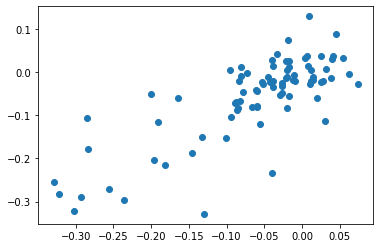

In [93]:
plt.scatter(mkt_returns, asset_returns)

In [94]:
std_ratio

1.0200055509886712

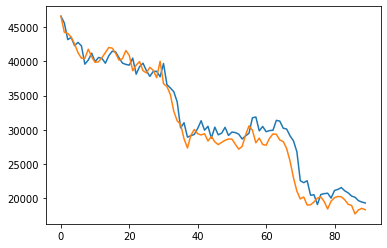

In [95]:
plt.plot(final[column][-days:].values)
sc = final[column][-days] / final[mkt_name][-days]
plt.plot(final[mkt_name][-days:].values*sc)

In [96]:
cov

0.007199776709886772

In [97]:
beta

0.8086665407710542

In [98]:
var

0.008903270194686019

In [99]:
np.corrcoef(mkt_returns, asset_returns)

array([[1.        , 0.78325414],
       [0.78325414, 1.        ]])

## 15 - Market Alpha (median)

In [100]:
def alpha_med(df, days, m_data, horizon):
    
    data = df.join(m_data)
    ind_returns = data['^TNX'].diff(periods = horizon) / 100
    returns =  data.drop('^TNX', axis=1).pct_change(periods = horizon)
    returns = returns.join(ind_returns)
    alfa = pd.DataFrame()
    
    for col in df.columns:
        
        returns_red = returns[[col, '^TNX', '^CMC200']][-days:].dropna()
        
        asset_returns = returns_red[col]
        rf_returns = returns_red['^TNX']
        ind_returns = returns_red['^CMC200']
        
        cov = np.cov(asset_returns, ind_returns)[0,1]
        var = np.var(ind_returns)
        
        beta = cov / var
        alfa.loc[col,'alfa'] = (asset_returns - rf_returns - beta * (ind_returns - rf_returns)).median()
        
    return alfa

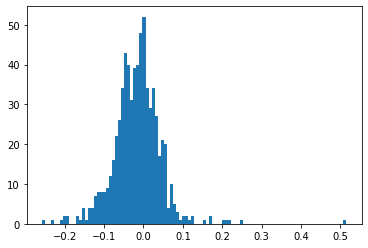

In [101]:
plt.hist(alpha_med(price_df, 90, m_data, 10).values,bins = 100);

In [ ]:
def Sharpe_ratio(data, period, Rf):
    R = data.pct_change()*100
    rf = Rf.name
    df = pd.DataFrame(Rf).merge(R, how='inner', left_index = True, right_index = True)
    df = df[-days:]
    Sharpe_ratio = pd.DataFrame()
    
    for col in data.columns:
        Diff = df[col] - df[rf]
        vol = Diff.var()**0.5
        vol_d = Diff[Diff < 0].var()**0.5
        Sharpe_ratio.loc[col,'Sharpe ratio'] = (Diff / vol).median()
        Sharpe_ratio.loc[col,'Sotrino ratio'] = (Diff / vol_d).median()
        
    return Sharpe_ratio

## 17 - Amivest Ratio

In [ ]:
def amivest(data_price, data_volume, period):
    
    R = data_price.pct_change()
    V = data_volume

    amivest = pd.DataFrame()
    for col in data_price.columns:
    
        df_merge = pd.merge(pd.DataFrame(R[col]), pd.DataFrame(V[col]), left_index=True, right_index=True)

        df_merge = df_merge[-period:].dropna()

        df_merge.columns = ['return', 'volume']
        amivest.loc[col,'amivest'] = df_merge['volume'].sum() / abs(df_merge['return']).sum() / period
    
    return amivest

In [ ]:
def Downside_deviation(data, c=0, n=90):
    returns = data.pct_change()
    DD = pd.DataFrame()
    for j, col in enumerate(data.columns):
        s = 0
        for i in range(1,n+1):
            if returns.iloc[-i,j] < c:
                s+= returns.iloc[-i,j]**2
        DD.loc[col,'Downside deviation'] = (s/n)**0.5
    return DD

## weighed_spread_Depth

In [ ]:
def weighed_spread_Depth(binance_data_df):
    df = binance_data_df.copy()
    S_V = df['bid_ask_spread_percentage'] * df['volume']
    S_D = df['cost_to_move_down_usd'] * df['volume']
    S_U = df['cost_to_move_up_usd'] * df['volume']
    
    df['S_V'] = df['bid_ask_spread_percentage'] * df['volume']
    df['S_D'] = df['cost_to_move_down_usd']
    df['S_U'] = df['cost_to_move_up_usd']
    
    Volume_sum = df.groupby(['symbol']).volume.sum()
    S_V_sum = df.groupby(['symbol']).S_V.sum()
    S_D_sum = df.groupby(['symbol']).S_D.sum()
    S_U_sum = df.groupby(['symbol']).S_U.sum()
    
    S_U_weighed = S_U_sum 
    S_D_weighed = S_D_sum 
    S_V_weighed = S_V_sum / Volume_sum
    
    weighed_df = pd.DataFrame(index=S_V_weighed.index)
    weighed_df['S_U_weighed'] = S_U_weighed
    weighed_df['S_D_weighed'] = S_D_weighed
    weighed_df['S_V_weighed'] = S_V_weighed
    return weighed_df

## COL_percentage

In [102]:
def COL_percentage(high_df , low_df , close_df, binance_data_df):
    
    x = pd.Series(index=binance_data_df['symbol'].unique())


    for column in binance_data_df['symbol'].unique():
        x[column] = ((0.5*(high_df[column]-low_df[column]))/close_df[column]).mean()
    return x 

## LIX

In [103]:
def LIX(high_df,low_df,close_df, vol_df , binance_data_df):
    
    x = pd.Series(index=binance_data_df['symbol'].unique())
    dates = high_df.index.tolist()
    vol_df_new = vol_df.loc[dates[0]:dates[-1]]
    
    for column in binance_data_df['symbol'].unique():
        x[column] = np.log10(((vol_df_new[column]*close_df[column])/(high_df[column]*low_df[column]))).mean()
    return x 

# Features

In [114]:
features_df = pd.DataFrame() 
log_returns = 100*(np.log(price_df) - np.log(price_df.shift(1))).dropna()
# features_df['max_dd_365d'] = max_dd_365d(log_returns)
features_df['std_90d'] = std(log_returns, 90)
# features_df['vol_avg_90d'] = np.log(vol_avg(vol_df, 90))

# features_df['Волатильность'] = std(log_returns, 90)
# features_df['Объем торгов'] = np.log(vol_avg(vol_df, 90))
features_df['vol_med_90d'] = np.log(vol_med(vol_df, 90))
# features_df['vol_7d_avg_min_90d'] = np.log(vol_roll_avg_min(vol_df, 90, 7))
# features_df['mean_turnover'] = MeanTurnOver2(90, vol_df, mcap_df)
features_df['Оборот'] = MeanTurnOver2(90, vol_df, mcap_df)
# features_df['mcap_med_90d'] = np.log(mcap_med(mcap_df, 90)) 
# features_df['min_turnover'] = min_turnover(90, vol_df, mcap_df)

# features_df['Максимальная просадка'] = Max_draw_down(price_df)
# features_df['Показатель предельного риска'] = VaR(price_df, 0.95 , 365, 1)
# features_df['Ожидаемы потери'] = ESFL(price_df, 0.95 , 365, 1)
# features_df['Roll_spread'] = Roll_spread(price_df)

features_df['mdd'] = Max_draw_down(price_df)
# features_df['VaR_95_1d'] = VaR(price_df, 0.95 , 365, 1)
# features_df['ESFL_95_1d'] = ESFL(price_df, 0.95 , 365, 1)


# features_df['amihud'] = -np.log(amihud(price_df, vol_df, 90)) #-np.log(amihud(price_df, vol_df))
# features_df['EPaS'] = np.log(EPaS(price_df , vol_df, Rf, '^TNX'))
# features_df['beta'], features_df['std_ratio_mkt'] = Beta_coef(price_df, 90, M_prices ,'^CMC200', 10) 
# features_df['std_ratio_eth'] = std_ratio_base(price_df, 90, 'ethereum')
# features_df['vol_btc'] = vol_bitc(price_df,90)
# features_df['downside_std'] = Downside_deviation(price_df, c=0, n=90)
# features_df['alpha']  = alpha_med(price_df, 90, m_data, 10)
# features_df['sharpe']= norm.cdf(Sharpe_ratio(price_df, 90, Rf)['Sharpe ratio'])
# features_df['sotrino']= norm.cdf(Sharpe_ratio(price_df, 90, Rf)['Sotrino ratio'])
# features_df['amivest'] = np.log(amivest(price_df, vol_df, 90))

#features_df = features_df.drop(columns=["beta"], axis=1)
#features_df = features_df.drop(columns=["VAR", 'vol_med_90d', 'Amivest', 'vol_7d_avg_min_90d', 'MDD'], axis = 1)
features_df

,std_90d,vol_med_90d,Оборот,mdd
superrare,12.698408,15.872076,22.903897,-95.037735
ufo-gaming,10.644919,15.083967,5.084011,-98.364007
ethereum-classic,6.421958,19.599223,11.563619,-81.666059
switcheo,7.701582,10.140981,0.259053,-88.444981
ooki,16.498749,15.278881,33.311787,-94.496358
...,...,...,...,...
sentinel-protocol,8.221404,14.908197,25.730423,-78.370823
stepn,12.871607,20.595869,105.166467,-84.713559
veed,8.769961,11.926498,1.572196,-87.608541
nuls,10.452991,15.917573,44.689901,-86.616357


In [ ]:
# features_slipage_df = pd.DataFrame() 
# features_slipage_df['S_U_weighed'] = weighed_spread_Depth(binance_data_df)['S_U_weighed']
# features_slipage_df['S_D_weighed'] = weighed_spread_Depth(binance_data_df)['S_D_weighed']
# features_slipage_df['S_V_weighed'] = weighed_spread_Depth(binance_data_df)['S_V_weighed']
# features_slipage_df['COL'] = COL_percentage(high_df,low_df,close_df, binance_data_df)
# features_slipage_df['LIX'] = LIX(high_df,low_df,close_df,vol_df, binance_data_df)
# features_slipage_df

In [ ]:
features_slipage_df[features_slipage_df.index == 'osmosis']

In [107]:
len(features_df.columns)

3

In [108]:
features_df = features_df[features_df['sotrino']>0.01]
features_df = features_df[features_df['amihud']>0]
features_df = features_df[features_df['beta']>0]

KeyError: 'sotrino'

In [115]:
features_df = features_df[features_df['Оборот'] < 100]# features_df = features_df[features_df['Roll_spread'] < 1]

In [ ]:
#features_df[features_df['mean_turnover'] > 100]

In [ ]:
features_df.isna().sum()

In [334]:
# features_df = features_df.drop(columns =['max_dd_365d', 'std_90d', 'vol_avg_90d', 'vol_med_90d'
#        ])
features_df.columns

Index(['max_dd_365d', 'std_90d', 'vol_avg_90d', 'vol_med_90d',
       'vol_7d_avg_min_90d', 'mean_turnover', 'mcap_med_90d', 'min_turnover',
       'mdd', 'VaR_95_1d', 'ESFL_95_1d', 'amihud', 'beta', 'std_ratio_mkt',
       'std_ratio_eth', 'vol_btc', 'downside_std', 'alpha', 'sharpe',
       'sotrino', 'amivest'],
      dtype='object')

In [56]:

metric = 'mdd'
z = features_df[metric]
print('bad')
print(z['komodo'])
print(z['qredo'])
print(z['cratos'])
print(z['cortex'])
print(z['tokocrypto'])
print('good')
print(z['ethereum'])
print(z['bitcoin'])
print(z['cardano'])
print(z['solana'])
print(z['cosmos'])
print('max-min')
print(features_df[metric].min())
print(features_df[metric].max())

bad
-88.41372728399995
-95.9179653232575
-93.58132617739071
-90.1780573814557
-91.84790154925955
good
-79.33018460301267
-71.8304369472731
-84.80501074928156
-89.12474370241002
-86.09628143271547
max-min
-99.83491958540765
-5.544387195955851


Silhouette Score bigest better: 0.5654213354110046
Calinski-Harabasz (n=2) bigest better: 2174.6243110117007
davies_bouldin_score lower better (n=2): 0.5075930384951081


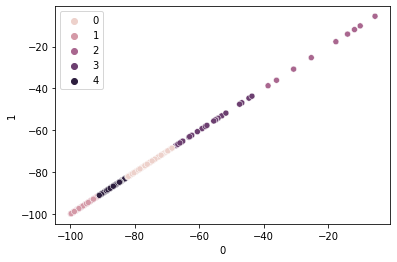

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline


X = np.array(features_df['mdd'])
X = X.reshape(686,1)
Y = np.array(features_df['mdd'])
Y = Y.reshape(686,1)
Z = np.concatenate((X,Y),axis=1)

Z = pd.DataFrame(Z)
KMean= KMeans(n_clusters=5)
KMean.fit(Z)
label=KMean.predict(Z)
sns.scatterplot(Z[0],Z[1],hue=label)
print(f'Silhouette Score bigest better: {silhouette_score(X, label)}')
# ‘cityblock’
# ‘cosine’
# ‘euclidean’
# ‘haversine’
# ‘l2’
# ‘manhattan’
# ‘nan_euclidean’
from sklearn import metrics
from sklearn.metrics import pairwise_distances
print(f'Calinski-Harabasz (n=2) bigest better: {metrics.calinski_harabasz_score(X, label)}')
from sklearn.metrics import davies_bouldin_score
print(f'davies_bouldin_score lower better (n=2): {davies_bouldin_score(X, label)}')

# Feature analysis

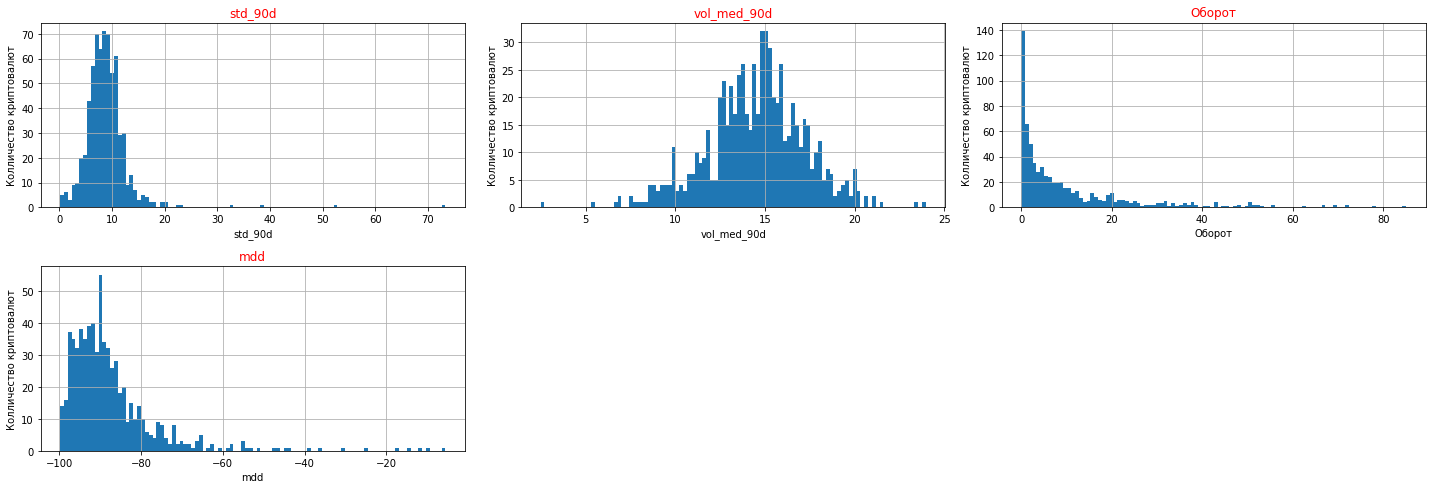

In [116]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=100,ax=ax)
        ax.set_title(feature,color='red')
        ax.set_xlabel(feature)
        ax.set_ylabel('Колличество криптовалют')

    fig.tight_layout()  
    plt.show()
    
histograms_plot(features_df,features_df.columns,6,3)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
dataplot = sb.heatmap(features_df.corr(), cmap="YlGnBu", annot=True)

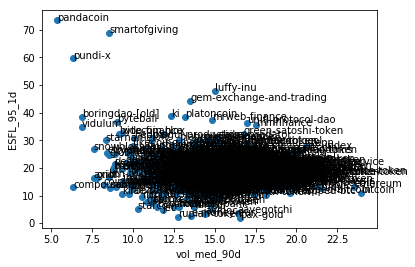

In [109]:
fig, ax = plt.subplots()
x = features_df['vol_med_90d'].values
y = features_df['ESFL_95_1d'].values
ax.scatter(x,y)
ax.set_xlabel('vol_med_90d')
ax.set_ylabel('ESFL_95_1d')
for i, txt in enumerate(features_df['max_dd_365d'].index):
    ax.annotate(txt, (x[i], y[i]))

In [329]:
# calculate Q1 and Q3
Q1 = features_df.quantile(0.25)
Q3 = features_df.quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# filter the dataset with the IQR
IQR_outliers = features_df[((features_df < (Q1 - 3 * IQR)) |(features_df > (Q3 + 3 * IQR))).any(axis=1)]
#IQR_outliers = features_df[((features_df < (Q1 - 3 * IQR))).any(axis=1)]
#features_df = features_df[~((features_df < (Q1 - 1.5 * IQR)) |(features_df > (Q3 + 1.5 * IQR))).any(axis=1)]
outliers_list_IQR = IQR_outliers.index
IQR_outliers

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,amihud,beta,std_ratio_mkt,alpha,amivest
santos-fc-fan-token,43.999468,15.826539,16.540979,21.972462,18.487854,1.787728,5.071198,0.048593,14.804680
hedpay,34.437751,10.039879,17.037516,30.809914,4.885781,1.155653,2.549215,0.050659,8.714513
zoid-pay,29.356592,12.308716,18.512423,19.983534,14.325291,1.981634,5.171774,0.070678,11.387335
defi-kingdoms,48.411455,15.369610,17.895639,28.652395,17.423557,0.888934,1.446403,-0.257714,14.011431
swftcoin,32.402239,14.917013,16.193585,21.537384,17.338397,1.517452,4.645520,0.077931,13.270863
starname,50.475656,8.329646,15.067592,29.976730,10.499315,1.956536,5.277480,0.004997,6.928100
bella-protocol,54.508320,15.709688,17.660202,28.626523,18.455183,3.015320,6.259921,0.172809,15.314195
jupiter,49.143917,12.691584,15.944080,27.308772,15.172166,0.087628,7.199341,-0.132881,11.443165
platoncoin,68.938464,13.202173,18.393619,38.567626,14.006120,1.844382,3.157306,0.248743,11.237841
bytecoin,161.565302,9.139877,17.883262,32.428564,12.140923,0.966391,4.135579,-0.017351,7.146356


In [330]:
outliers_list_IQR

Index(['santos-fc-fan-token', 'hedpay', 'zoid-pay', 'defi-kingdoms',
       'swftcoin', 'starname', 'bella-protocol', 'jupiter', 'platoncoin',
       'bytecoin', 'bitcoin', 'unifi-protocol-dao', 'shiba-predator',
       'gem-exchange-and-trading', 'pandacoin', 'binancecoin', 'ki',
       'boringdao-[old]', 'gods-unchained', 'snowblossom', 'ichi-farm',
       'ethereum', 'lith-token', 'cult-dao', 'luffy-inu',
       'celsius-degree-token', 'global-coin-research'],
      dtype='object')

In [1347]:
outliers_list = outliers_list_IQR
features_df = features_df.drop(outliers_list, axis=0)

## Binning

### BCA Binning (Mars Risk Framework)

In [47]:
def cut_binning(df, bins, coeff_info):
    
    if bins==4:
        cut_labels = ["very bad", "bad", "medium", "good"]
        score = ['A', 'B', 'C', 'D']
    if bins==5:
        cut_labels = ["very bad", "bad", "medium", "good", "very good"]
        score = ['AA', 'A', 'B', 'C', 'D']
        
    result_df = pd.DataFrame(columns=df.columns, index = df.index)
    results_table = pd.DataFrame(columns=df.columns, index = score)
    counts = []
    
    for column in df.columns:
        
        check_sign = coeff_info['Sign of dependence'][coeff_info['Coefficient'] == column]
        
        if int(check_sign)==1:
            cut_labels_used = cut_labels[::-1]
        else:
            cut_labels_used = cut_labels

        results, bin_edges = pd.cut(df[column], bins=bins, labels=cut_labels_used, retbins=True)
        categories = pd.cut(df[column], bins=bins).value_counts().index.categories
        
        counts.append(pd.cut(df[column], bins=bins, labels=cut_labels_used).value_counts())
        
        round_categories = pd.IntervalIndex([
        pd.Interval(round(i.left,1), round(i.right,1), i.closed)
        for i in categories
        ])
        
        result_df[column] = results
        results_table[column] = round_categories
        
        if int(check_sign)==-1:
            results_table[column] = results_table[column].values[::-1]
        
    return results_table, result_df, pd.DataFrame(counts).transpose()

In [48]:
def qcut_binning(df, bins, coeff_info):
    
    if bins == 4:
        cut_labels = ["very bad", "bad", "medium", "good"]
        score = ['A', 'B', 'C', 'D']
        quantiles = [0, 0.25, 0.5, 0.75, 1]
    if bins == 5:
        cut_labels = ["very bad", "bad", "medium", "good", "very good"]
        score = ['AA', 'A', 'B', 'C', 'D']
        quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1]
        
    result_df = pd.DataFrame(columns=df.columns, index = df.index)
    results_table = pd.DataFrame(columns=df.columns, index = score)
    counts = []
    
    for column in df.columns:
        
        check_sign = coeff_info['Sign of dependence'][coeff_info['Coefficient'] == column]
        
        if int(check_sign) == 1:
            cut_labels_used = cut_labels[::-1]
        else:
            cut_labels_used = cut_labels

        results, bin_edges = pd.qcut(df[column], q=quantiles, labels=cut_labels_used, retbins=True)
        categories = pd.qcut(df[column], q=quantiles).value_counts().index.categories
        
        counts.append(pd.qcut(df[column],  q=quantiles, labels=cut_labels_used).value_counts())
        
        round_categories = pd.IntervalIndex([
        pd.Interval(round(i.left,1), round(i.right,1), i.closed)
        for i in categories
        ])
        
        result_df[column] = results
        results_table[column] = round_categories# bin_edges
        
        if int(check_sign) == -1:
            results_table[column] = results_table[column].values[::-1]
        
    return results_table, result_df, pd.DataFrame(counts).transpose()

In [49]:
def combined_binning(df, ratings_num, coeff_info, first_q, last_q):
    
    #cut_labels = ["very bad", "bad", "medium", "good", "very good"]
    cut_labels = ['AA', 'A', 'B', 'C', 'D']
    counts = pd.DataFrame(index = cut_labels)

    ratings_df = pd.DataFrame(columns=df.columns, index = df.index)
    bounds_df = pd.DataFrame(columns=df.columns)

    for column in df.columns:

        check_sign = coeff_info['Sign of dependence'][coeff_info['Coefficient'] == column]
        bounds = []
        df_col = df[column]
        ratings = []

        if int(check_sign) == -1:
            df_col = -df_col

        bounds.append(np.quantile(df_col, first_q))
        last = np.quantile(df_col, last_q)

        delta = abs((last - bounds[0])) / (ratings_num - 2) 

        for i in range(1, ratings_num - 2):
                 bounds.append(bounds[i-1] + delta)

        bounds.append(last)
        ratings = np.digitize(df_col, bounds)

        labels = np.array(cut_labels)[ratings]
        c = pd.DataFrame(pd.Series(labels).value_counts(), columns = [column])
        counts = counts.merge(c, left_index=True, right_index=True)

        ratings_df[column] = labels
        if int(check_sign) == -1:
            bounds = Convert(bounds) 

        bounds_df[column] = bounds 
        
    return bounds_df, ratings_df, counts

In [50]:
def Convert(lst):
    lst = np.array(lst)
    return list(-lst)

In [51]:
coeff_info = pd.read_csv('E:/Scripts/coeffs.csv', sep=';')

In [202]:
bounds_df, ratings_df, counts = combined_binning(features_df, 5, coeff_info, 0.05, 0.9)

In [203]:
ratings_df.loc['railgun']

max_dd_365d      A
vol_med_90d      C
mcap_med_90d     B
ESFL_95_1d       B
beta             D
std_ratio_mkt    C
amivest          C
Name: railgun, dtype: object

In [204]:
ratings_df.loc['ethereum']

max_dd_365d       A
vol_med_90d      AA
mcap_med_90d     AA
ESFL_95_1d        A
beta              B
std_ratio_mkt     A
amivest          AA
Name: ethereum, dtype: object

In [205]:
ratings_df.loc['bitcoin']

max_dd_365d       A
vol_med_90d      AA
mcap_med_90d     AA
ESFL_95_1d        A
beta              B
std_ratio_mkt     A
amivest          AA
Name: bitcoin, dtype: object

In [206]:
counts

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest
AA,35,35,35,35,35,35,35
A,204,137,73,133,97,239,153
B,231,283,192,288,252,277,264
C,155,170,325,169,241,74,173
D,70,70,70,70,70,70,70


In [207]:
bounds_df

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest
0,11.764912,18.809393,21.290051,10.779560,0.254934,0.959870,17.451317
1,24.149274,16.252599,19.679375,15.370535,0.650622,1.543687,14.995356
2,36.533637,13.695805,18.068698,19.961510,1.046310,2.127504,12.539395
3,48.917999,11.139011,16.458021,24.552485,1.441997,2.711321,10.083434


In [208]:
ratings_df

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest
superrare,C,B,C,C,D,C,B
ufo-gaming,C,B,C,C,C,C,B
ethereum-classic,A,AA,AA,A,B,A,AA
switcheo,B,D,D,C,B,B,D
ooki,D,B,C,D,C,C,B
...,...,...,...,...,...,...,...
stepn,C,AA,A,D,D,D,AA
veed,B,C,C,A,B,B,C
mrweb-finance,D,B,D,D,B,D,B
nuls,C,B,C,C,B,B,B


In [214]:
# bounds_df, ratings_df, counts = cut_binning(features_df, 5, coeff_info)
# ratings_df
# ratings_df

In [209]:
weights_BCA = [1, 0.7, 0.5, 0.3, 0.1]

subjects = {"very good" : 1.0,
            "good" : 0.7,
            "medium" : 0.5,
            "bad" : 0.3,
            "very bad" : 0.1}

subjects = {"AA" : 1.0,
            "A" : 0.7,
            "B" : 0.5,
            "C" : 0.3,
            "D" : 0.1}

transformed_features_ms = ratings_df.copy()
for column in ratings_df.columns:
    transformed_features_ms[column] = ratings_df[column].map(subjects)
    
transformed_features_ms['total score'] = transformed_features_ms.mean(axis=1)
transformed_features_ms.sort_values(by="total score", ascending=False)

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest,total score
pax-gold,1.0,0.7,0.7,1.0,1.0,1.0,1.0,0.914286
ftx-token,1.0,0.7,1.0,1.0,0.7,1.0,0.7,0.871429
leo-token,1.0,0.5,1.0,1.0,1.0,1.0,0.5,0.857143
aavegotchi,1.0,0.7,0.5,1.0,1.0,1.0,0.7,0.842857
wrapped-bitcoin,1.0,1.0,1.0,0.7,0.5,0.7,1.0,0.842857
...,...,...,...,...,...,...,...,...
byteball,0.1,0.1,0.1,0.1,0.5,0.1,0.1,0.157143
pandacoin,0.1,0.1,0.1,0.1,0.5,0.1,0.1,0.157143
pundi-x,0.1,0.1,0.3,0.1,0.3,0.1,0.1,0.157143
smartofgiving,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.100000


In [210]:
transformed_features_ms.loc[lst]

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest,total score
komodo,0.3,0.5,0.3,0.5,0.5,0.7,0.5,0.471429
qredo,0.1,0.5,0.3,0.3,0.3,0.5,0.5,0.357143
cratos,0.7,0.5,0.5,0.5,1.0,0.7,0.5,0.628571
cudos,0.5,0.5,0.3,0.5,0.5,0.5,0.3,0.442857
cortex,0.3,0.5,0.3,0.3,0.3,0.5,0.5,0.385714
railgun,0.7,0.3,0.5,0.5,0.1,0.3,0.3,0.385714
tokocrypto,0.3,0.5,0.3,0.5,0.3,0.7,0.5,0.442857
cardano,0.7,1.0,1.0,0.7,0.5,0.7,1.0,0.800000
solana,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.714286
cosmos,0.7,1.0,1.0,0.5,0.5,0.5,1.0,0.742857


In [64]:
transformed_features_ms.loc['bitcoin']

max_dd_365d      0.7
vol_med_90d      1.0
mcap_med_90d     1.0
ESFL_95_1d       0.7
beta             0.5
std_ratio_mkt    0.7
amivest          1.0
total score      0.8
Name: bitcoin, dtype: float64

In [65]:
transformed_features_ms.loc['ethereum']

max_dd_365d      0.7
vol_med_90d      1.0
mcap_med_90d     1.0
ESFL_95_1d       0.7
beta             0.5
std_ratio_mkt    0.7
amivest          1.0
total score      0.8
Name: ethereum, dtype: float64

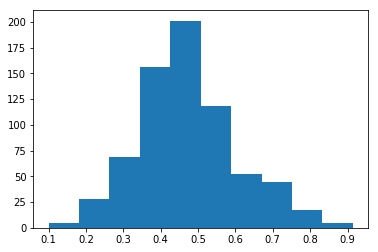

In [66]:
plt.hist(transformed_features_ms['total score']);

In [211]:
labels, bounds, bin_counts = mix_bin(transformed_features_ms['total score'], 5, 0.1, 0.95)

In [212]:
transformed_features_ms['quality'] = labels
quality = transformed_features_ms['quality']

In [213]:
transformed_features_ms.groupby('quality')[['total score']].mean()

,total score
quality,
bad,0.378164
good,0.635646
medium,0.493905
very bad,0.248950
very good,0.774603


# Data Normalization

## Quantile normalization

In [78]:
transformed_features_qn = quantile_norm(features_df, coeff_info)
transformed_features_mm = normalize(features_df, coeff_info)
#transformed_features['total_score'] = transformed_features.sum(axis=1)

4
0
0
2
0
6
0


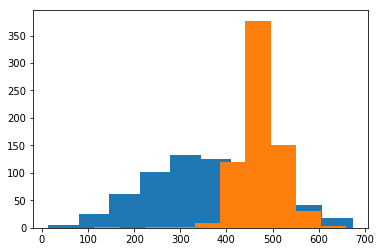

In [79]:
plt.hist(transformed_features_qn.sum(axis=1));
plt.hist(transformed_features_mm.sum(axis=1));

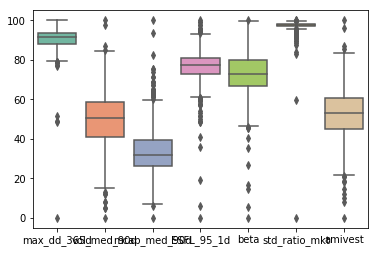

In [81]:
ax = sb.boxplot(data=transformed_features_mm, palette="Set2")

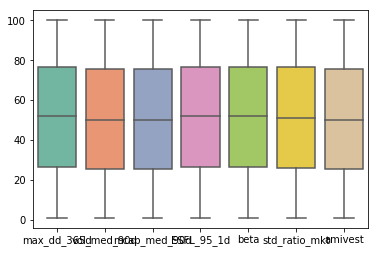

In [1374]:
ax = sb.boxplot(data=transformed_features_qn, palette="Set2")

## Aggregation

In [657]:
# scores_df = features_df.merge(transformed_data.add_suffix('_score'), left_index=True, right_index=True)
# scores_df['sum score'] = scores_df[scores_df.filter(like='score').columns].sum(axis=1)
# scores_df

In [82]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [83]:
transformed_features_mm.corr()

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest
max_dd_365d,1.000000,0.066575,0.159908,0.806506,0.371092,0.356230,0.152550
vol_med_90d,0.066575,1.000000,0.686622,0.153133,-0.114879,0.056480,0.982104
mcap_med_90d,0.159908,0.686622,1.000000,0.210177,-0.014402,0.103074,0.696445
ESFL_95_1d,0.806506,0.153133,0.210177,1.000000,0.387705,0.466732,0.258922
beta,0.371092,-0.114879,-0.014402,0.387705,1.000000,0.179488,-0.068833
std_ratio_mkt,0.356230,0.056480,0.103074,0.466732,0.179488,1.000000,0.118166
amivest,0.152550,0.982104,0.696445,0.258922,-0.068833,0.118166,1.000000


In [84]:
transformed_features_qn.corr()

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest
max_dd_365d,1.000000,-0.115970,0.140116,0.829207,0.361566,0.585917,-0.043502
vol_med_90d,-0.115970,1.000000,0.656636,0.018747,-0.175900,0.043005,0.979977
mcap_med_90d,0.140116,0.656636,1.000000,0.199259,-0.071256,0.214376,0.667966
ESFL_95_1d,0.829207,0.018747,0.199259,1.000000,0.411125,0.715813,0.103400
beta,0.361566,-0.175900,-0.071256,0.411125,1.000000,0.624524,-0.140434
std_ratio_mkt,0.585917,0.043005,0.214376,0.715813,0.624524,1.000000,0.112855
amivest,-0.043502,0.979977,0.667966,0.103400,-0.140434,0.112855,1.000000


In [85]:
features_df.corr()

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest
max_dd_365d,1.000000,-0.066575,-0.159908,0.806506,0.371092,0.356230,-0.152550
vol_med_90d,-0.066575,1.000000,0.686622,-0.153133,0.114879,-0.056480,0.982104
mcap_med_90d,-0.159908,0.686622,1.000000,-0.210177,0.014402,-0.103074,0.696445
ESFL_95_1d,0.806506,-0.153133,-0.210177,1.000000,0.387705,0.466732,-0.258922
beta,0.371092,0.114879,0.014402,0.387705,1.000000,0.179488,0.068833
std_ratio_mkt,0.356230,-0.056480,-0.103074,0.466732,0.179488,1.000000,-0.118166
amivest,-0.152550,0.982104,0.696445,-0.258922,0.068833,-0.118166,1.000000


In [86]:
def agg_corr(df, corr_tr):
    C = df.corr().values
    C[abs(df.corr().values) < corr_tr]=0

    #mC = 1 - abs(C)
    #np.fill_diagonal(mC, 1)
    #print(is_pos_def(C))
    a = []
    for i in range(df.shape[0]):
        w = df.values[i]
        a.append(np.sqrt(np.dot(np.dot(w, C), w.T)))

    return a

In [ ]:
#features_df.to_csv('E:/Scripts/features_df_extended.csv', sep=';') 

In [742]:
#plot_pair_scatterplots(transformed_data_qn, 'pair correlations')  

# PCA Weights

In [87]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from factor_analyzer.factor_analyzer import calculate_kmo

In [88]:
def pca_weights(data, variance_tr):
    
    kmo_all, kmo_model = calculate_kmo(data)
    #print(kmo_model)
    
    n_comps = data.shape[1]
    fa = FactorAnalyzer(n_factors=n_comps, method='principal', rotation="varimax")
    fa.fit(data)
    # PC_values = np.arange(n_comps) + 1
    # plt.plot(PC_values, fa.get_factor_variance()[2], 'ro-', linewidth=2)
    # plt.title('Scree Plot')
    # plt.xlabel('Principal Component')
    # plt.ylabel('Cumulative Variance Explained')
    # plt.show()
    
    n_comps = n_comps - sum(fa.get_factor_variance()[2]>variance_tr)
    fa = FactorAnalyzer(n_factors=n_comps, method='principal', rotation="varimax")
    fa.fit(data)
    loadings_fa = fa.loadings_
    ev, v = fa.get_eigenvalues()
    #print(pd.DataFrame(fa.loadings_.round(2),index=data.columns))
    #print(ev)
    #fa.get_params().keys()
    
    expl_tot = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
    df = pd.DataFrame(loadings_fa**2, index = data.columns)
    loadings_norm = df / np.array(df.sum(axis=0))

    cols = []
    for i in range(n_comps):
        cols.append('PC %i'% (i+1))

    loadings_norm = pd.DataFrame(data = loadings_norm)
    loadings_norm.columns = cols
    #print(loadings_norm)
    
    col_numbers = loadings_norm.columns.get_indexer(loadings_norm.apply('idxmax', axis=1))
    weights = loadings_norm.max(axis = 1) * expl_tot[col_numbers]
    weights_norm = weights / sum(weights)

    #w = pd.DataFrame(weights_norm, index = loadings_norm.index).rename(columns={0: "weights"}).sort_values(by="weights", ascending=True)
    #w.plot.barh()
    #plt.title('PCA Metrics Weights')
    #plt.xlabel('Weights')
    #plt.show()
    
    return weights_norm

#If you use principal components to extract factors, the variance equals the eigenvalue. You can use the size of the eigenvalue to determine the number of factors. Retain the factors with the largest eigenvalues. For example, using the Kaiser criterion, you use only the factors with eigenvalues that are greater than 1.

In [90]:
pca_weights(transformed_features_qn, 0.9)

max_dd_365d      0.153899
vol_med_90d      0.165546
mcap_med_90d     0.128705
ESFL_95_1d       0.149477
beta             0.154588
std_ratio_mkt    0.081279
amivest          0.166506
dtype: float64

# Weighted Score

In [91]:
transformed_features_qn_final = transformed_features_qn.copy()
transformed_features_mm_final = transformed_features_mm.copy()

transformed_features_qn_final['total_score_corr'] = agg_corr(transformed_features_qn, 0.3)
transformed_features_mm_final['total_score_corr'] = agg_corr(transformed_features_mm, 0.3)

In [92]:
transformed_features_qn_final['total_score_pca'] = (transformed_features_qn * pca_weights(transformed_features_qn, 0.9).values).sum(axis=1)
transformed_features_mm_final['total_score_pca'] = (transformed_features_mm * pca_weights(transformed_features_mm, 0.9).values).sum(axis=1)

In [93]:
transformed_features_qn_final['total_sum'] = transformed_features_qn.sum(axis=1)
transformed_features_mm_final['total_sum'] = transformed_features_mm.sum(axis=1)

In [94]:
transformed_features_qn_final

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest,total_score_corr,total_score_pca,total_sum
superrare,17,71,40,23,6,15,65,173.014786,35.925852,237
ufo-gaming,15,57,57,11,24,20,49,160.344380,34.219541,233
ethereum-classic,83,97,97,85,53,80,98,369.904943,85.034605,593
switcheo,65,7,6,27,59,48,7,164.689666,30.157946,219
ooki,1,61,18,6,20,15,60,137.874698,27.767076,181
...,...,...,...,...,...,...,...,...,...,...
stepn,18,100,92,6,4,8,99,269.975286,49.815233,327
veed,66,16,15,81,49,35,13,198.877035,39.428425,275
mrweb-finance,1,53,1,1,71,1,44,121.209175,27.589291,172
nuls,13,72,20,18,47,44,71,187.037731,41.848524,285


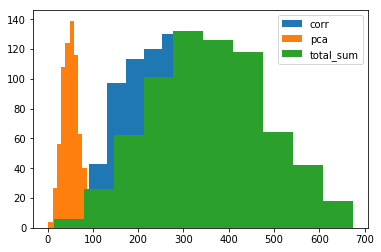

In [95]:
plt.hist(transformed_features_qn_final['total_score_corr'], label='corr');
plt.hist(transformed_features_qn_final['total_score_pca'], label='pca');
plt.hist(transformed_features_qn_final['total_sum'], label='total_sum' );
plt.legend()

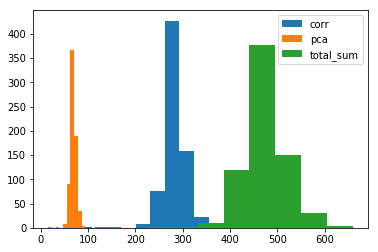

In [97]:
plt.hist(transformed_features_mm_final['total_score_corr'], label='corr');
plt.hist(transformed_features_mm_final['total_score_pca'], label='pca');
plt.hist(transformed_features_mm_final['total_sum'], label='total_sum' );
plt.legend();

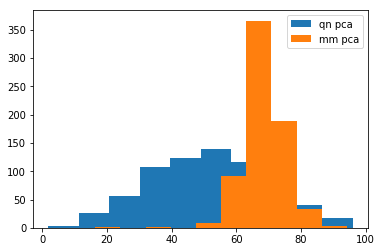

In [98]:
plt.hist(transformed_features_qn_final['total_score_pca'], label='qn pca');
plt.hist(transformed_features_mm_final['total_score_pca'], label='mm pca');
plt.legend();

In [99]:
print(transformed_features_qn_final['total_score_pca'].mean())
print(transformed_features_mm_final['total_score_pca'].mean())

50.92776610024161
68.60030845806199


In [100]:
print(transformed_features_qn_final['total_score_corr'].mean())
print(transformed_features_mm_final['total_score_corr'].mean())

234.59991099597192
282.83128096397036


In [101]:
print(transformed_features_qn_final['total_sum'].mean())
print(transformed_features_mm_final['total_sum'].mean())

356.5568345323741
474.0842450859453


## Binning

In [91]:
def q_cut(df_col):
    cut_labels = ["very bad", "bad", "medium", "good", 'very good']
    quality = pd.qcut(df_col, q=[0, .2, .4, .6, .8, 1], labels=cut_labels)
    
    labels, bounds = pd.qcut(df_col, q=[0, .2, .4, .6, .8, 1], labels=cut_labels, retbins = True)
    
    results_table = pd.DataFrame(zip(bounds, cut_labels),
                            columns=['Threshold', 'Tier'])
    
    bin_counts = pd.qcut(df_col, q=[0, .2, .4, .6, .8, 1], labels=cut_labels).value_counts()
    
    return labels, bounds, bin_counts 

In [92]:
def cut(df_col):
    cut_labels = ["very bad", "bad", "medium", "good", 'very good']
    cut_bins = np.linspace(df_col.min(), df_col.max(), 6)
    quality = pd.cut(df_col, bins=cut_bins, labels=cut_labels)
    labels, bounds = pd.cut(df_col, bins=cut_bins, labels=cut_labels, retbins = True)
    
    results_table = pd.DataFrame(zip(bounds, cut_labels),
                            columns=['Threshold', 'Tier'])
    
    bin_counts = pd.cut(df_col, bins=cut_bins, labels=cut_labels).value_counts()
    
    return labels, bounds, bin_counts 

In [93]:
def mix_bin(df_col, ratings_num, first_q, last_q):
    
    bounds = []
    cut_labels = ["very bad", "bad", "medium", "good", 'very good']
    #cut_labels = ["very good", "good", "medium", "bad", 'very bad']
    
    bounds.append(np.quantile(df_col, first_q))
    last = np.quantile(df_col, last_q)
        
    delta = (last - bounds[0]) / (ratings_num - 2)
        
    for i in range(1, ratings_num - 2):
        bounds.append(bounds[i-1] + delta)
            
    bounds.append(last)
    ratings = np.digitize(df_col, bounds)
    
    x = np.array(cut_labels)[ratings]
    unique, counts = np.unique(x, return_counts=True)
    bin_counts = np.asarray((unique, counts)).T
    labels = np.array(cut_labels)[ratings]

    return labels, bounds, bin_counts

In [94]:
def mix_bin_1(df_col, ratings_num, first_q, last_q , cut_labels):
    
    bounds = []
    #cut_labels = ["very good", "good", "medium", "bad", 'very bad']
    
    bounds.append(np.quantile(df_col, first_q))
    last = np.quantile(df_col, last_q)
        
    delta = (last - bounds[0]) / (ratings_num - 2)
        
    for i in range(1, ratings_num - 2):
        bounds.append(bounds[i-1] + delta)
            
    bounds.append(last)
    ratings = np.digitize(df_col, bounds)
    
    x = np.array(cut_labels)[ratings]
    unique, counts = np.unique(x, return_counts=True)
    bin_counts = np.asarray((unique, counts)).T
    labels = np.array(cut_labels)[ratings]

    return labels, bounds, bin_counts

In [95]:
features_df.columns

Index(['Волатильность', 'Объем торгов', 'Оборот', 'Максимальная просадка',
       'Показатель предельного риска', 'Ожидаемы потери', 'Roll_spread'],
      dtype='object')

In [96]:
cut_labels = ["very bad", "bad", "medium", "good", 'very good']
labels, bounds, bin_counts = mix_bin_1(features_df['mdd'], 5, 0.2, 0.95, cut_labels)

KeyError: 'mdd'

In [120]:
def mix_bin_Dataframe(df, ratings_num, first_q, last_q , cut_labels, coeff_info):
    #define dataframes to return
    labels_df = pd.DataFrame(index=df.index)
    bin_counts_df = pd.DataFrame()
    bounds_df = pd.DataFrame()
    
    for column in df.columns:
        
        check_sign = coeff_info['Sign of dependence'][coeff_info['Coefficient'] == column]
        
        if int(check_sign)==1:
            cut_labels_used = cut_labels[::-1]
            labels, bounds, bin_counts = mix_bin_1(df[column], ratings_num, first_q, last_q, cut_labels_used)
            labels_df[column] = labels
            bin_counts_df[column] = [x for x in bin_counts]
            bounds_df[column] = [x for x in bounds][::-1]
        else:
            cut_labels_used = cut_labels
            labels, bounds, bin_counts = mix_bin_1(df[column], ratings_num, first_q, last_q, cut_labels_used)
            labels_df[column] = labels
            bin_counts_df[column] = [x for x in bin_counts]
            bounds_df[column] = [x for x in bounds]

    return labels_df,bin_counts_df,  bounds_df

In [121]:
features_df.describe()

,std_90d,vol_med_90d,mdd
count,686.000000,686.000000,686.000000
mean,8.874780,14.569710,87.342963
std,4.563717,2.734995,11.780903
min,0.154295,2.480051,5.544387
25%,6.672528,12.969872,84.763420
50%,8.551781,14.744081,90.090712
75%,10.448759,16.300363,94.326754
max,73.303261,23.970197,99.834920


In [122]:
coeff_info = pd.read_csv('coeffs.csv', sep=';')
cut_labels = ["very bad", "bad", "medium", "good", 'very good']
cut_labels = [1,2,3,4,5]
labels_df,bin_counts_df,  bounds_df = mix_bin_Dataframe(features_df, 5, 0.2, 0.95, cut_labels, coeff_info)
labels_df

,std_90d,vol_med_90d,mdd
superrare,2,3,2
ufo-gaming,3,3,1
ethereum-classic,4,5,5
switcheo,4,1,3
ooki,1,3,2
...,...,...,...
sentinel-protocol,4,3,5
stepn,2,5,4
veed,4,1,4
nuls,3,3,4


In [59]:
bounds_df

NameError: name 'bounds_df' is not defined

In [124]:
labels_df.loc[:,'Total'] = labels_df.sum(axis=1)

In [125]:
labels_df.sort_values(by='Total')

,std_90d,vol_med_90d,mdd,Total
pandacoin,1,1,1,3
ionomy,1,1,1,3
math,1,1,2,4
boringdao-[old],1,1,2,4
platypus-finance,1,2,1,4
...,...,...,...,...
binancecoin,5,5,5,15
ethereum,5,5,5,15
ripple,5,5,5,15
wrapped-bitcoin,5,5,5,15


In [476]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
features_df_quality = features_df.copy()
features_df_quality['quality'] = labels_df['max_dd_365d']
# features_df_quality


**Silhouette Score**:
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.


**davies_bouldin_score**:
This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.
Zero is the lowest possible score. Values closer to zero indicate a better partition.


**Calinski-Harabasz**:
If the ground truth labels are not known, the Calinski-Harabasz index - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

In [449]:
def binning_score_1_class_label_many_features(df,name_class_label):
    score_df = pd.DataFrame(index=['Calinski_Harabasz','davies_bouldin_score','Silhouette_Score'])
    
    data_df = df.copy()
    df_class_label = data_df[name_class_label]
    data_df.pop(name_class_label).copy()
    
    X = np.array(data_df).reshape(data_df.shape[0],data_df.shape[1])
    label = np.array(df_class_label).reshape(len(df_class_label),1)
    
    Calinski_Harabasz = metrics.calinski_harabasz_score(X, label)
    davies_bouldin = davies_bouldin_score(X, label)
    Silhouette = silhouette_score(X, label)
                            
    score_df[name_class_label] = [round(Calinski_Harabasz,3),
                        round(davies_bouldin,3),
                        round(Silhouette,3)]
    return score_df
binning_score_1_class_label_many_features(features_df_quality, 'quality')
# Calinski-Harabasz : 100.61076530971589
# davies_bouldin_score: 2.319965731905076
# Silhouette Score bigger: 0.08797604335198572

,quality
Calinski_Harabasz,100.611
davies_bouldin_score,2.320
Silhouette_Score,0.088


In [450]:
def binning_score_many_class_labels_many_features(df,labels_df):
    score_df = pd.DataFrame(index=['Calinski_Harabasz','davies_bouldin_score','Silhouette_Score'])
    data_df = df.copy()
    data_labels_df = labels_df.copy()
    
    for col in features_df.columns:
        
        X = np.array(data_df[col]).reshape(len(data_df[col]),1)
        label = np.array(data_labels_df[col]).reshape(len(data_labels_df[col]),1)
        
        Calinski_Harabasz = metrics.calinski_harabasz_score(X, label)
        davies_bouldin = davies_bouldin_score(X, label)
        Silhouette = silhouette_score(X, label)
                            
        score_df[col] = [round(Calinski_Harabasz,3),
                         round(davies_bouldin,3),
                         round(Silhouette,3)]
    return score_df
binning_score_many_class_labels_many_features(features_df,labels_df)

,max_dd_365d,std_90d,vol_avg_90d,vol_med_90d,vol_7d_avg_min_90d,mean_turnover,min_turnover,mdd,VaR_95_1d,ESFL_95_1d,amihud,beta,std_ratio_mkt,std_ratio_eth,vol_btc,downside_std,alpha,sharpe,sotrino,amivest
Calinski_Harabasz,672.488,479.327,1417.515,1347.938,1408.591,1730.225,1384.388,387.499,380.947,688.153,680.998,1185.021,31.718,43.690,46.530,871.102,634.351,935.962,1204.509,1253.007
davies_bouldin_score,0.633,0.659,0.546,0.542,0.539,0.573,0.623,0.591,0.655,0.634,0.588,0.582,1.030,1.046,1.031,0.620,0.688,0.603,0.592,0.562
Silhouette_Score,0.517,0.477,0.508,0.502,0.522,0.325,0.286,0.401,0.494,0.502,0.467,0.493,0.443,0.464,0.428,0.480,0.476,0.476,0.483,0.504


In [451]:
def binning_score_1_class_label_1_feature(feature_series,labels_series):
    score_df = pd.DataFrame(index=['Calinski_Harabasz','davies_bouldin_score','Silhouette_Score'])
    
    X = np.array(feature_series).reshape(len(feature_series),1)
    label = np.array(labels_series).reshape(len(labels_series),1)
    
    Calinski_Harabasz = metrics.calinski_harabasz_score(X, label)
    davies_bouldin = davies_bouldin_score(X, label)
    Silhouette = silhouette_score(X, label)

    score_df[feature_series.name] = [round(Calinski_Harabasz,3),
                     round(davies_bouldin,3),
                     round(Silhouette,3)]
    return score_df
binning_score_1_class_label_1_feature(features_df['max_dd_365d'],labels_df['max_dd_365d'])

,max_dd_365d
Calinski_Harabasz,672.488
davies_bouldin_score,0.633
Silhouette_Score,0.517


In [452]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
for col in features_df.columns:
    X = np.array(features_df[col]).reshape(len(features_df[col]),1)
    label = np.array(labels_df[col]).reshape(len(features_df[col]),1)
    print(col)
    print(f'Calinski-Harabasz (n=2) bigger is better : {metrics.calinski_harabasz_score(X, label)}')
    print(f'davies_bouldin_score smaller is better (n=2): {davies_bouldin_score(X, label)}')
    print(f'Silhouette Score bigger is better(-1,1): {silhouette_score(X, label)}')

max_dd_365d
Calinski-Harabasz (n=2) bigger is better : 672.4879348790256
davies_bouldin_score smaller is better (n=2): 0.633399265919517
Silhouette Score bigger is better(-1,1): 0.5167151851690316
std_90d
Calinski-Harabasz (n=2) bigger is better : 479.3271649967802
davies_bouldin_score smaller is better (n=2): 0.6589155514075
Silhouette Score bigger is better(-1,1): 0.47696864298796887
vol_avg_90d
Calinski-Harabasz (n=2) bigger is better : 1417.5150670304356
davies_bouldin_score smaller is better (n=2): 0.545713111497967
Silhouette Score bigger is better(-1,1): 0.5079160647116242
vol_med_90d
Calinski-Harabasz (n=2) bigger is better : 1347.9376735505402
davies_bouldin_score smaller is better (n=2): 0.5424730060753349
Silhouette Score bigger is better(-1,1): 0.5022653178389372
vol_7d_avg_min_90d
Calinski-Harabasz (n=2) bigger is better : 1408.5908930859443
davies_bouldin_score smaller is better (n=2): 0.5385183817902963
Silhouette Score bigger is better(-1,1): 0.5217966304412318
mean_tur

In [477]:
features_df.shape

(647, 20)

In [478]:
y_test = features_df_quality[500:647].copy()
y_train = features_df_quality[0:500].copy()

In [479]:
y_test 

,max_dd_365d,std_90d,vol_avg_90d,vol_med_90d,vol_7d_avg_min_90d,mean_turnover,min_turnover,mdd,VaR_95_1d,ESFL_95_1d,...,beta,std_ratio_mkt,std_ratio_eth,vol_btc,downside_std,alpha,sharpe,sotrino,amivest,quality
dock,27.261289,8.266674,15.553983,15.361843,13.799545,8.074911,0.859977,88.316253,11.902262,15.565437,...,1.162755,1.737657,1.433458,0.051079,0.054543,-0.000037,0.268744,0.201212,13.969857,good
get-token,43.258791,10.783124,10.436813,9.974028,9.382966,0.156715,0.004012,85.125226,10.806747,18.802850,...,0.939333,1.465593,1.861944,0.076504,0.056634,-0.010557,0.347775,0.259261,8.964453,bad
vires-finance,26.250138,7.804052,11.682678,11.447705,10.612128,0.372961,0.089646,79.408254,10.104218,15.806066,...,0.239541,1.074899,1.580138,0.075018,0.062326,-0.087288,0.278096,0.194624,9.974232,good
unifty,14.004598,4.836584,13.082480,12.502323,11.314455,0.903078,0.024881,88.064858,9.177127,12.282617,...,0.252932,1.212522,1.751652,0.088414,0.041607,-0.012463,0.333017,0.167348,11.614290,very good
milk-alliance,22.126915,6.569012,16.041506,15.544558,15.090496,7.032684,0.944334,82.775158,12.183526,16.207388,...,1.210772,1.497324,1.176964,0.038453,0.047859,0.027856,0.250655,0.206449,14.678960,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adex,24.519206,6.203897,15.395802,15.093175,14.621553,12.983823,3.248622,88.297235,8.655692,13.633470,...,0.833452,1.090992,1.108629,0.035706,0.045637,-0.036651,0.243934,0.195383,14.109950,good
sentinel-protocol,23.651694,8.221404,15.772216,14.908197,14.289336,25.730423,1.861354,78.370823,12.658640,16.862178,...,1.216170,1.631896,1.459517,0.058955,0.050270,0.052088,0.287404,0.204811,14.301535,good
veed,24.476761,8.769961,12.263013,11.926498,9.883124,1.572196,0.044243,87.608541,11.317459,14.889250,...,1.013392,1.869441,1.677818,0.074180,0.054578,0.062323,0.287506,0.166873,10.530687,good
nuls,47.044635,10.452991,16.447772,15.917573,14.922286,44.689901,11.916253,86.616357,11.445908,22.597970,...,1.033335,1.759143,1.652735,0.068110,0.064701,0.018582,0.342156,0.306779,14.833124,bad


In [480]:
features_df_quality.columns

Index(['max_dd_365d', 'std_90d', 'vol_avg_90d', 'vol_med_90d',
       'vol_7d_avg_min_90d', 'mean_turnover', 'min_turnover', 'mdd',
       'VaR_95_1d', 'ESFL_95_1d', 'amihud', 'beta', 'std_ratio_mkt',
       'std_ratio_eth', 'vol_btc', 'downside_std', 'alpha', 'sharpe',
       'sotrino', 'amivest', 'quality'],
      dtype='object')

In [481]:
y_train

,max_dd_365d,std_90d,vol_avg_90d,vol_med_90d,vol_7d_avg_min_90d,mean_turnover,min_turnover,mdd,VaR_95_1d,ESFL_95_1d,...,beta,std_ratio_mkt,std_ratio_eth,vol_btc,downside_std,alpha,sharpe,sotrino,amivest,quality
superrare,44.503928,12.698408,16.266338,15.872076,14.973763,22.903897,7.812633,95.037735,13.982716,21.710415,...,1.642196,2.436967,2.161129,0.093665,0.069663,0.042195,0.323721,0.230773,14.411565,bad
ufo-gaming,45.429798,10.644919,15.240380,15.083967,14.075943,5.084011,1.812585,98.364007,14.562298,24.551572,...,1.262660,2.179534,1.834723,0.069570,0.075042,-0.110599,0.303000,0.247606,13.460015,bad
ethereum-classic,18.703479,6.421958,19.820945,19.599223,18.910807,11.563619,4.008039,81.666059,10.882670,14.187332,...,0.982751,1.336227,1.219688,0.037172,0.048628,-0.032198,0.259367,0.201546,18.393071,very good
switcheo,24.620844,7.701582,10.622564,10.140981,7.643529,0.259053,0.002457,88.444981,14.834651,21.134203,...,0.936380,1.705487,1.634062,0.067323,0.061966,-0.057000,0.283711,0.213809,9.045136,good
ooki,67.327602,16.498749,15.905304,15.278881,14.430898,33.311787,7.982947,94.496358,15.647805,27.682434,...,1.309221,2.433635,2.857193,0.126109,0.078230,-0.004472,0.376377,0.282827,14.075034,very bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
koda-finance,23.439799,6.995688,9.206638,8.815959,7.558303,0.019843,0.000043,93.742378,12.065556,20.386939,...,1.767278,2.477075,1.361069,0.047877,0.055200,0.045385,0.281985,0.242082,7.786669,good
butterflydao,26.360567,10.824932,14.006343,12.779534,11.265929,1.234321,0.179553,99.660637,17.250324,20.766357,...,1.440035,2.211443,2.133886,0.085200,0.084225,-0.113219,0.259833,0.147591,11.965148,good
chiliz,28.176774,7.324424,18.629013,18.457769,18.017943,15.636958,7.187837,84.424948,9.460501,15.272906,...,0.954569,1.354803,1.253984,0.041937,0.050264,0.005225,0.237279,0.175209,17.160230,good
cortex,48.355314,11.927676,16.388321,15.848033,14.723360,35.701485,5.333828,90.178057,13.263018,23.045837,...,1.126826,1.790545,1.945861,0.090855,0.069373,0.032908,0.341735,0.270229,14.598879,bad


In [482]:
y_test

,max_dd_365d,std_90d,vol_avg_90d,vol_med_90d,vol_7d_avg_min_90d,mean_turnover,min_turnover,mdd,VaR_95_1d,ESFL_95_1d,...,beta,std_ratio_mkt,std_ratio_eth,vol_btc,downside_std,alpha,sharpe,sotrino,amivest,quality
dock,27.261289,8.266674,15.553983,15.361843,13.799545,8.074911,0.859977,88.316253,11.902262,15.565437,...,1.162755,1.737657,1.433458,0.051079,0.054543,-0.000037,0.268744,0.201212,13.969857,good
get-token,43.258791,10.783124,10.436813,9.974028,9.382966,0.156715,0.004012,85.125226,10.806747,18.802850,...,0.939333,1.465593,1.861944,0.076504,0.056634,-0.010557,0.347775,0.259261,8.964453,bad
vires-finance,26.250138,7.804052,11.682678,11.447705,10.612128,0.372961,0.089646,79.408254,10.104218,15.806066,...,0.239541,1.074899,1.580138,0.075018,0.062326,-0.087288,0.278096,0.194624,9.974232,good
unifty,14.004598,4.836584,13.082480,12.502323,11.314455,0.903078,0.024881,88.064858,9.177127,12.282617,...,0.252932,1.212522,1.751652,0.088414,0.041607,-0.012463,0.333017,0.167348,11.614290,very good
milk-alliance,22.126915,6.569012,16.041506,15.544558,15.090496,7.032684,0.944334,82.775158,12.183526,16.207388,...,1.210772,1.497324,1.176964,0.038453,0.047859,0.027856,0.250655,0.206449,14.678960,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adex,24.519206,6.203897,15.395802,15.093175,14.621553,12.983823,3.248622,88.297235,8.655692,13.633470,...,0.833452,1.090992,1.108629,0.035706,0.045637,-0.036651,0.243934,0.195383,14.109950,good
sentinel-protocol,23.651694,8.221404,15.772216,14.908197,14.289336,25.730423,1.861354,78.370823,12.658640,16.862178,...,1.216170,1.631896,1.459517,0.058955,0.050270,0.052088,0.287404,0.204811,14.301535,good
veed,24.476761,8.769961,12.263013,11.926498,9.883124,1.572196,0.044243,87.608541,11.317459,14.889250,...,1.013392,1.869441,1.677818,0.074180,0.054578,0.062323,0.287506,0.166873,10.530687,good
nuls,47.044635,10.452991,16.447772,15.917573,14.922286,44.689901,11.916253,86.616357,11.445908,22.597970,...,1.033335,1.759143,1.652735,0.068110,0.064701,0.018582,0.342156,0.306779,14.833124,bad


In [483]:
from pandas.api.types import CategoricalDtype


cat_type = CategoricalDtype(categories=cut_labels, ordered=True)
y_train["quality"] = y_train["quality"].astype(cat_type)
y_train["quality"].dtype
cat_type = CategoricalDtype(categories=cut_labels, ordered=True)
y_test["quality"] = y_test["quality"].astype(cat_type)
y_test["quality"].dtype

CategoricalDtype(categories=['very bad', 'bad', 'medium', 'good', 'very good'], ordered=True)

In [484]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
mod_prob = OrderedModel(y_train["quality"],
                        y_train[['std_90d', 'vol_avg_90d', 'vol_med_90d',
       'vol_7d_avg_min_90d', 'mean_turnover', 'min_turnover', 'mdd',
       'VaR_95_1d', 'ESFL_95_1d', 'amihud', 'beta', 'std_ratio_mkt',
       'std_ratio_eth', 'vol_btc', 'downside_std', 'alpha', 'sharpe',
       'sotrino', 'amivest']],
                        distr='probit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.635458
         Iterations: 155
         Function evaluations: 159
         Gradient evaluations: 159


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                quality   Log-Likelihood:                -317.73
Model:                   OrderedModel   AIC:                             681.5
Method:            Maximum Likelihood   BIC:                             778.4
Date:                Mon, 11 Jul 2022                                         
Time:                        11:25:26                                         
No. Observations:                 500                                         
Df Residuals:                     477                                         
Df Model:                          23                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
std_90d               -0.9043      0.083    -10.944      0.000      -1.066      -0.742
vol_avg_90d            1.5185      1.108      1.371      0.170      -0.652       3.689
vol_med_90d           -0.1625      0.219     -0.743      0.457      -0.591       0.266
vol_7d_avg_min_90d     0.1918      0.158      1.218      0.223      -0.117       0.501
mean_turnover         -0.0143      0.008     -1.789      0.074      -0.030       0.001
min_turnover           0.0326      0.033      0.986      0.324      -0.032       0.097
mdd                   -0.0195      0.010     -2.005      0.045      -0.039      -0.000
VaR_95_1d              0.4202      0.044      9.505      0.000       0.334       0.507
ESFL_95_1d            -0.1784      0.048     -3.694      0.000      -0.273      -0.084
amihud                -0.1608      0.100     -1.604      0.109      -0.357       0.036
beta                   0.2551      0.348      0.733      0.463      -0.427       0.937
std_ratio_mkt          0.3348      0.153      2.184      0.029       0.034       0.635
std_ratio_eth          1.7833      0.676      2.640      0.008       0.459       3.107
vol_btc               -9.0212     13.507     -0.668      0.504     -35.495      17.452
downside_std         -96.1620     29.815     -3.225      0.001    -154.599     -37.725
alpha                 -4.0026      2.249     -1.780      0.075      -8.410       0.405
sharpe                12.2074      5.197      2.349      0.019       2.022      22.393
sotrino              -15.7564      4.330     -3.639      0.000     -24.243      -7.270
amivest               -1.4400      1.065     -1.352      0.176      -3.528       0.648
very bad/bad         -14.4402      1.408    -10.256      0.000     -17.200     -11.681
bad/medium             0.8032      0.106      7.583      0.000       0.596       1.011
medium/good            0.9135      0.074     12.413      0.000       0.769       1.058
good/very good         0.9425      0.066     14.269      0.000       0.813       1.072
======================================================================================
"""

In [485]:
num_of_thresholds = 3
mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])

array([      -inf, 0.80320932, 3.29624474, 5.86267386,        inf])

In [486]:
predicted = res_prob.model.predict(res_prob.params, 
        exog=y_test[['std_90d', 'vol_avg_90d', 'vol_med_90d',
       'vol_7d_avg_min_90d', 'mean_turnover', 'min_turnover', 'mdd',
       'VaR_95_1d', 'ESFL_95_1d', 'amihud', 'beta', 'std_ratio_mkt',
       'std_ratio_eth', 'vol_btc', 'downside_std', 'alpha', 'sharpe',
       'sotrino', 'amivest']],)
predicted

array([[8.96506417e-10, 7.75257815e-05, 9.84829218e-02, 8.00573345e-01,
        1.00866207e-01],
       [3.31434230e-04, 1.20307496e-01, 7.86149837e-01, 9.31606265e-02,
        5.06064293e-05],
       [3.60945289e-09, 1.90387957e-04, 1.44377186e-01, 7.89451234e-01,
        6.59811880e-02],
       [3.93692929e-29, 2.57815546e-19, 7.00344309e-11, 5.92064146e-05,
        9.99940794e-01],
       [1.49359025e-13, 2.07137423e-07, 5.09583901e-03, 4.93781329e-01,
        5.01122625e-01],
       [3.33900870e-06, 1.15699671e-02, 5.76281188e-01, 4.09497529e-01,
        2.64797661e-03],
       [1.90055687e-05, 2.95912429e-02, 6.98292584e-01, 2.71342576e-01,
        7.54592043e-04],
       [3.41739031e-23, 1.29224661e-14, 1.49118442e-07, 5.26170854e-03,
        9.94738142e-01],
       [2.13709456e-03, 2.64016334e-01, 7.03003637e-01, 3.08383300e-02,
        4.60412525e-06],
       [1.38296695e-23, 6.38491584e-15, 9.18734503e-08, 4.04070492e-03,
        9.95959203e-01],
       [6.91910669e-09, 2.8797

In [487]:
pred_choice = predicted.argmax(1)
print('Fraction of correct choice predictions')
print((np.asarray(y_test['quality'].values.codes) == pred_choice).mean())
y_test['pred'] = pred_choice +1
y_test

Fraction of correct choice predictions
0.7551020408163265


,max_dd_365d,std_90d,vol_avg_90d,vol_med_90d,vol_7d_avg_min_90d,mean_turnover,min_turnover,mdd,VaR_95_1d,ESFL_95_1d,...,std_ratio_mkt,std_ratio_eth,vol_btc,downside_std,alpha,sharpe,sotrino,amivest,quality,pred
dock,27.261289,8.266674,15.553983,15.361843,13.799545,8.074911,0.859977,88.316253,11.902262,15.565437,...,1.737657,1.433458,0.051079,0.054543,-0.000037,0.268744,0.201212,13.969857,good,4
get-token,43.258791,10.783124,10.436813,9.974028,9.382966,0.156715,0.004012,85.125226,10.806747,18.802850,...,1.465593,1.861944,0.076504,0.056634,-0.010557,0.347775,0.259261,8.964453,bad,3
vires-finance,26.250138,7.804052,11.682678,11.447705,10.612128,0.372961,0.089646,79.408254,10.104218,15.806066,...,1.074899,1.580138,0.075018,0.062326,-0.087288,0.278096,0.194624,9.974232,good,4
unifty,14.004598,4.836584,13.082480,12.502323,11.314455,0.903078,0.024881,88.064858,9.177127,12.282617,...,1.212522,1.751652,0.088414,0.041607,-0.012463,0.333017,0.167348,11.614290,very good,5
milk-alliance,22.126915,6.569012,16.041506,15.544558,15.090496,7.032684,0.944334,82.775158,12.183526,16.207388,...,1.497324,1.176964,0.038453,0.047859,0.027856,0.250655,0.206449,14.678960,good,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adex,24.519206,6.203897,15.395802,15.093175,14.621553,12.983823,3.248622,88.297235,8.655692,13.633470,...,1.090992,1.108629,0.035706,0.045637,-0.036651,0.243934,0.195383,14.109950,good,4
sentinel-protocol,23.651694,8.221404,15.772216,14.908197,14.289336,25.730423,1.861354,78.370823,12.658640,16.862178,...,1.631896,1.459517,0.058955,0.050270,0.052088,0.287404,0.204811,14.301535,good,4
veed,24.476761,8.769961,12.263013,11.926498,9.883124,1.572196,0.044243,87.608541,11.317459,14.889250,...,1.869441,1.677818,0.074180,0.054578,0.062323,0.287506,0.166873,10.530687,good,4
nuls,47.044635,10.452991,16.447772,15.917573,14.922286,44.689901,11.916253,86.616357,11.445908,22.597970,...,1.759143,1.652735,0.068110,0.064701,0.018582,0.342156,0.306779,14.833124,bad,2


In [488]:
predicted.argmax(1)+1

array([4, 3, 4, 5, 5, 3, 3, 5, 3, 5, 4, 2, 3, 5, 4, 1, 5, 2, 4, 1, 4, 2,
       4, 4, 3, 4, 4, 4, 4, 5, 3, 4, 2, 5, 4, 5, 3, 5, 3, 5, 5, 3, 4, 5,
       4, 4, 5, 5, 5, 4, 3, 2, 4, 2, 5, 5, 3, 4, 4, 3, 5, 3, 2, 5, 4, 4,
       3, 2, 4, 5, 1, 5, 4, 3, 5, 4, 2, 4, 5, 2, 4, 1, 2, 3, 4, 4, 3, 2,
       4, 5, 4, 2, 4, 5, 2, 4, 4, 4, 4, 5, 2, 4, 4, 4, 2, 4, 4, 5, 4, 4,
       4, 4, 5, 3, 2, 5, 2, 2, 4, 1, 3, 4, 4, 4, 4, 5, 4, 3, 5, 2, 3, 5,
       4, 2, 5, 4, 4, 3, 5, 5, 4, 2, 4, 4, 4, 2, 3], dtype=int64)

In [334]:
y_test

,max_dd_365d,std_90d,vol_avg_90d,vol_med_90d,vol_7d_avg_min_90d,mean_turnover,min_turnover,mdd,VaR_95_1d,ESFL_95_1d,...,std_ratio_mkt,std_ratio_eth,vol_btc,downside_std,alpha,sharpe,sotrino,amivest,quality,pred
dock,27.261289,8.266674,15.553983,15.361843,13.799545,8.074911,0.859977,88.316253,11.902262,15.565437,...,1.737657,1.433458,0.051079,0.054543,-0.000037,0.268744,0.201212,13.969857,good,4
get-token,43.258791,10.783124,10.436813,9.974028,9.382966,0.156715,0.004012,85.125226,10.806747,18.802850,...,1.465593,1.861944,0.076504,0.056634,-0.010557,0.347775,0.259261,8.964453,bad,2
vires-finance,26.250138,7.804052,11.682678,11.447705,10.612128,0.372961,0.089646,79.408254,10.104218,15.806066,...,1.074899,1.580138,0.075018,0.062326,-0.087288,0.278096,0.194624,9.974232,good,4
unifty,14.004598,4.836584,13.082480,12.502323,11.314455,0.903078,0.024881,88.064858,9.177127,12.282617,...,1.212522,1.751652,0.088414,0.041607,-0.012463,0.333017,0.167348,11.614290,very good,5
milk-alliance,22.126915,6.569012,16.041506,15.544558,15.090496,7.032684,0.944334,82.775158,12.183526,16.207388,...,1.497324,1.176964,0.038453,0.047859,0.027856,0.250655,0.206449,14.678960,good,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adex,24.519206,6.203897,15.395802,15.093175,14.621553,12.983823,3.248622,88.297235,8.655692,13.633470,...,1.090992,1.108629,0.035706,0.045637,-0.036651,0.243934,0.195383,14.109950,good,4
sentinel-protocol,23.651694,8.221404,15.772216,14.908197,14.289336,25.730423,1.861354,78.370823,12.658640,16.862178,...,1.631896,1.459517,0.058955,0.050270,0.052088,0.287404,0.204811,14.301535,good,4
veed,24.476761,8.769961,12.263013,11.926498,9.883124,1.572196,0.044243,87.608541,11.317459,14.889250,...,1.869441,1.677818,0.074180,0.054578,0.062323,0.287506,0.166873,10.530687,good,4
nuls,47.044635,10.452991,16.447772,15.917573,14.922286,44.689901,11.916253,86.616357,11.445908,22.597970,...,1.759143,1.652735,0.068110,0.064701,0.018582,0.342156,0.306779,14.833124,bad,2


In [533]:
labels, bounds, bin_counts = mix_bin(transformed_features_qn_final['total_score_pca'], 5, 0.2, 0.95)

NameError: name 'transformed_features_qn_final' is not defined

In [174]:
#labels, bounds, bin_counts  = cut(transformed_features_qn_final['total_score_pca'])

In [181]:
bin_counts

array([['bad', '209'],
       ['good', '103'],
       ['medium', '209'],
       ['very bad', '139'],
       ['very good', '35']], dtype='<U21')

In [184]:
bounds

[35.219924429953075, 50.65862457322965, 66.09732471650624, 81.53602485978281]

In [187]:
transformed_features_qn_final['quality'] = labels
quality = transformed_features_qn_final['quality']

ltv_df = pd.DataFrame()
period = 365
level = 0.99
ltv_df['ESFL_95_1d'] = VaR(price_df, level, period, 1)
ltv_df['ESFL_95_2d'] = VaR(price_df, level, period, 2)
ltv_df['ESFL_95_3d'] = VaR(price_df, level, period, 3)
ltv_df['ESFL_95_4d'] = VaR(price_df, level, period, 4)
ltv_df['ESFL_95_5d'] = VaR(price_df, level, period, 7)

ltv_df = ltv_df.merge(quality, left_index=True, right_index=True)
ltv_df.groupby('quality')[['ESFL_95_1d','ESFL_95_2d', 'ESFL_95_3d', 'ESFL_95_4d', 'ESFL_95_5d']].quantile(0.99)

,ESFL_95_1d,ESFL_95_2d,ESFL_95_3d,ESFL_95_4d,ESFL_95_5d
quality,,,,,
bad,38.022030,50.568295,59.101054,64.120239,68.229998
good,22.365789,33.093388,35.747653,43.531306,55.125107
medium,26.691929,39.872566,46.987836,51.627396,59.224982
very bad,72.592776,77.967729,82.035928,83.459092,83.851799
very good,20.196623,24.441807,30.907503,39.171077,42.202998


In [177]:
transformed_features_qn_final['total_score_pca'].sort_values()

smartofgiving       1.937778
starname            3.470326
stake-dao          10.426855
rainbow-token-2    10.717768
pundi-x            11.404895
                     ...    
ripple             91.386134
wrapped-bitcoin    92.347655
bitcoin            92.974648
pax-gold           94.276207
ftx-token          95.975244
Name: total_score_pca, Length: 695, dtype: float64

In [183]:
lst = ['komodo',
'qredo',
'cratos',
'cudos',
'cortex',
'railgun',
'tokocrypto',
'cardano',
'solana',
'cosmos',
'ftx-token',
'bitcoin',
'ethereum']

transformed_features_qn_final.loc[lst]

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest,total_score_corr,total_score_pca,total_sum,quality
komodo,29,37,34,61,53,66,44,205.204194,44.966184,324,bad
qredo,6,70,42,22,45,46,68,196.318021,43.223431,299,bad
cratos,82,65,75,64,98,84,59,326.133238,74.400500,527,good
cudos,50,36,40,50,77,52,31,212.346207,47.568104,336,bad
cortex,12,71,29,16,37,41,68,182.466147,40.099241,274,bad
railgun,73,24,72,39,3,14,24,161.572195,35.901922,249,bad
tokocrypto,19,74,30,53,43,62,71,223.356285,50.466438,352,bad
cardano,80,99,100,81,75,79,100,380.053035,88.344867,614,very good
solana,54,100,100,67,70,62,100,346.585706,80.261688,553,good
cosmos,72,98,97,70,52,61,97,343.360726,79.399714,547,good


In [188]:
labels, bounds, bin_counts = mix_bin(transformed_features_mm_final['total_score_pca'], 5, 0.1, 0.95)
#labels, bounds, bin_counts  = q_cut(transformed_features_mm_final['total_score_pca'])
print(bin_counts)

[['bad' '191']
 ['good' '95']
 ['medium' '304']
 ['very bad' '70']
 ['very good' '35']]


In [191]:
transformed_features_mm_final['quality'] = labels
quality = transformed_features_mm_final['quality']

ltv_df = pd.DataFrame()
period = 365
level = 0.99
ltv_df['ESFL_95_1d'] = VaR(price_df, level, period, 1)
ltv_df['ESFL_95_2d'] = VaR(price_df, level, period, 2)
ltv_df['ESFL_95_3d'] = VaR(price_df, level, period, 3)
ltv_df['ESFL_95_4d'] = VaR(price_df, level, period, 4)
ltv_df['ESFL_95_5d'] = VaR(price_df, level, period, 5)

ltv_df = ltv_df.merge(quality, left_index=True, right_index=True)
ltv_df.groupby('quality')[['ESFL_95_1d','ESFL_95_2d', 'ESFL_95_3d', 'ESFL_95_4d', 'ESFL_95_5d']].median()

,ESFL_95_1d,ESFL_95_2d,ESFL_95_3d,ESFL_95_4d,ESFL_95_5d
quality,,,,,
bad,21.245080,31.350456,36.211562,42.580684,45.327423
good,17.633818,24.105376,28.763287,34.132223,35.726315
medium,19.114363,27.180248,32.200543,37.791114,40.351627
very bad,27.552560,36.315246,41.853428,45.092059,47.849826
very good,16.173306,19.994983,25.182888,29.376048,32.264918


In [190]:
# final_df = scores_df.sort_values(by=['sum score'], ascending=False)
# final_df['quality']

In [135]:
transformed_features_mm_final.loc[lst]

,max_dd_365d,vol_med_90d,mcap_med_90d,ESFL_95_1d,beta,std_ratio_mkt,amivest,total_score_corr,total_score_pca,total_sum,quality
komodo,88.338784,45.274010,28.184097,78.754664,73.316764,97.977458,50.877559,276.699947,67.055515,462.723337,medium
qredo,82.873629,56.337225,29.627849,72.160540,71.573747,97.617663,58.540042,275.289374,68.108632,468.730695,medium
cratos,94.489944,54.249641,39.233785,79.222895,95.243053,98.293057,55.605498,303.132323,74.782563,516.337873,good
cortex,85.101277,56.396121,27.136679,70.423045,69.466528,97.531333,58.400365,273.529002,67.575768,464.455347,medium
railgun,93.440118,40.020532,38.171263,75.248626,46.753699,96.513318,44.538012,263.475973,62.462184,434.685569,bad
tokocrypto,86.848563,57.462040,27.236357,77.707428,70.940579,97.903594,59.721210,282.590054,69.422889,477.819769,medium
cardano,94.263135,81.560358,75.170176,81.844513,79.411408,98.189030,81.206192,342.775405,84.866623,591.644813,very good
solana,91.557850,84.698333,74.083354,79.622953,77.965128,97.890080,82.769539,341.110071,84.510190,588.587238,very good
cosmos,93.340463,77.121055,61.924974,80.088893,73.254701,97.882418,76.337521,325.421652,80.568801,559.950024,very good
bitcoin,96.818106,100.000000,100.000000,87.198420,76.725122,98.685881,100.000000,386.089288,94.134664,659.427530,very good
